In [ ]:
# Para visualización en notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (8,6)

# Números y Datos
import numpy as np
import pandas as pd

import networkx as nx
import community.community_louvain as community_louvain
from sklearn.metrics import adjusted_rand_score

from glob import glob
from pathlib import Path

import copy as cp

# Defino funciones

## subjectmatrix2graphslist()

In [ ]:
def subjectmatrix2graphslist(filename, densities):
    """
    Toma un archivo csv con la matriz de input y devuelve una lista de grafos con la densisdad de aristas correspondiente
    """
    
    correlation_matrix = pd.read_csv(filename, header=None)
    n = correlation_matrix.shape[0]
    correlation_matrix -= np.diag(np.ones(n))
    max_links = (n*n-n)//2
    tril_idx = np.tril_indices(n,-1)
    sorted_correlations = sorted(correlation_matrix.values[tril_idx].flatten(),reverse=True)
    
    Gs = []
    for d in densities:
        idx = int(d*max_links)
        threshold = sorted_correlations[idx]
        Gs.append(nx.from_pandas_adjacency(correlation_matrix>=threshold))
        
    return Gs

# Cargo datos

Y hago una red para cada uno.
Hay que definir la densidad. Aca elegí arbitrariamente 0.2

In [ ]:
!wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
!unzip -q DataSujetos

In [ ]:
filenames_N1 = list(Path('DataSujetos').glob('N1_*.csv'))
filenames_N2 = list(Path('DataSujetos').glob('N2_*.csv'))
filenames_N3 = list(Path('DataSujetos').glob('N3_*.csv'))
filenames_W  = list(Path('DataSujetos').glob('W_*.csv'))

In [ ]:
densities = [0.075]
graphs_N1 = {}
for filename in filenames_N1:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N1[name] = Gs
graphs_N2 = {}
for filename in filenames_N2:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N2[name] = Gs
graphs_N3 = {}
for filename in filenames_N3:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_N3[name] = Gs
graphs_W = {}
for filename in filenames_W:
    Gs = subjectmatrix2graphslist(filename, densities)
    name = Path(filename).stem
    graphs_W[name] = Gs

# Tarea 4

## Armo comunidades y calculo ARI observado

In [ ]:
ari_W = []
for n, i in enumerate(dict(list(graphs_W.items())[:-1])):
  # genero la red para el individuo i
  G1 = graphs_W[i][0]
  com1 = list(community_louvain.best_partition(G1).values())
  for j in dict(list(graphs_W.items())[n+1:]):
    G2 = graphs_W[j][0]
    com2 = list(community_louvain.best_partition(G2).values())
    ari = adjusted_rand_score(com1, com2)
    ari_W.append(ari)

ari_N1 = []
for n, i in enumerate(dict(list(graphs_N1.items())[:-1])):
  # genero la red para el individuo i
  G1 = graphs_N1[i][0]
  com1 = list(community_louvain.best_partition(G1).values())
  for j in dict(list(graphs_N1.items())[n+1:]):
    G2 = graphs_N1[j][0]
    com2 = list(community_louvain.best_partition(G2).values())
    ari = adjusted_rand_score(com1, com2)
    ari_N1.append(ari)

ari_N2 = []
for n, i in enumerate(dict(list(graphs_N2.items())[:-1])):
  # genero la red para el individuo i
  G1 = graphs_N2[i][0]
  com1 = list(community_louvain.best_partition(G1).values())
  for j in dict(list(graphs_N2.items())[n+1:]):
    G2 = graphs_N2[j][0]
    com2 = list(community_louvain.best_partition(G2).values())
    ari = adjusted_rand_score(com1, com2)
    ari_N2.append(ari)

ari_N3 = []
for n, i in enumerate(dict(list(graphs_N3.items())[:-1])):
  # genero la red para el individuo i
  G1 = graphs_N3[i][0]
  com1 = list(community_louvain.best_partition(G1).values())
  for j in dict(list(graphs_N3.items())[n+1:]):
    G2 = graphs_N3[j][0]
    com2 = list(community_louvain.best_partition(G2).values())
    ari = adjusted_rand_score(com1, com2)
    ari_N3.append(ari)

In [ ]:
print("W")
print(np.mean(ari_W))
print(np.std(ari_W))
print("\nN1")
print(np.mean(ari_N1))
print(np.std(ari_N1))
print("\nN2")
print(np.mean(ari_N2))
print(np.std(ari_N2))
print("\nN3")
print(np.mean(ari_N3))
print(np.std(ari_N3))

W
0.26723959377798345
0.09612407458053465

N1
0.32261324930241625
0.10310802364239907

N2
0.37754905562447794
0.10412413365702958

N3
0.3269244480642479
0.12872840630222154


Text(0, 0.5, 'ARI')

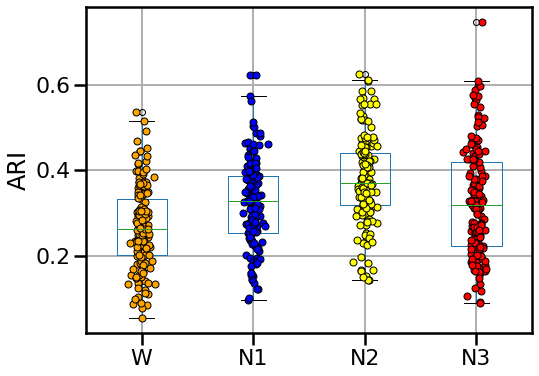

In [ ]:
data = pd.DataFrame({ "W": ari_W,
                      "N1": ari_N1, 
                      "N2": ari_N2,
                      "N3": ari_N3})

data.boxplot()

for i,d in enumerate(data):
    y = data[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, mfc = ["orange","blue","yellow","red"][i], mec='k', ms=7, marker="o", linestyle="None")
plt.ylabel('ARI')


## Permuto

In [ ]:
# Armo df con la comunidad de cada nodo para cada estadio
# cada fila un nodo, cada columna un individuo

df_W = pd.DataFrame()
for n, i in enumerate(dict(list(graphs_W.items()))):
  G = graphs_W[i][0]
  com = list(community_louvain.best_partition(G).values())
  name = i
  name = name.split("_")[1]
  df_W.insert(n, name, com, True)

df_N1 = pd.DataFrame()
for n, i in enumerate(dict(list(graphs_N1.items()))):
  G = graphs_N1[i][0]
  com = list(community_louvain.best_partition(G).values())
  name = i
  name = name.split("_")[1]
  df_N1.insert(n, name, com, True)

df_N2 = pd.DataFrame()
for n, i in enumerate(dict(list(graphs_N2.items()))):
  G = graphs_N2[i][0]
  com = list(community_louvain.best_partition(G).values())
  name = i
  name = name.split("_")[1]
  df_N2.insert(n, name, com, True)

df_N3 = pd.DataFrame()
for n, i in enumerate(dict(list(graphs_N3.items()))):
  G = graphs_N3[i][0]
  com = list(community_louvain.best_partition(G).values())
  name = i
  name = name.split("_")[1]
  df_N3.insert(n, name, com, True)

In [ ]:
#def permuta(data1, data2):
#  df1 = cp.deepcopy(data1)
#  df2 = cp. deepcopy(data2)
#  individuos = df1.columns
#  largo = df1.shape[0]
#  for i in individuos:
#    for j in range(largo):
#      if np.random.uniform(0, 1) > 0.5:
#        a = cp.deepcopy(df1.loc[j, i])
#        b = cp.deepcopy(df2.loc[j, i])
#        df1.loc[j, i] = b
#        df2.loc[j, i] = a
#  return df1, df2

def permuta(data1, data2):
  df1 = cp.deepcopy(data1)
  df2 = cp. deepcopy(data2)
  individuos = df1.columns
  largo = df1.shape[0]
  for i in individuos:
    if np.random.uniform(0, 1) > 0.5:
      a = cp.deepcopy(df1.loc[:, i])
      b = cp.deepcopy(df2.loc[:, i])
      df1.loc[:, i] = b
      df2.loc[:, i] = a
  return df1, df2

In [ ]:
def calcula_ari(df):
  ari_list = []
  individuos = df.columns
  for n, i in enumerate(individuos[:-1]):
    for j in individuos[n+1:]:
      ari = adjusted_rand_score(df[i], df[j])
      ari_list.append(ari)
  media = np.mean(ari_list)
  sd = np.std(ari_list)
  return media, sd

In [ ]:
def permuta_y_calcula_ari(data1, data2, N):
  media_lista = []
  sd_lista = []
  for i in range(N):
    if i % 10 == 0:
      print("iteracion numero "+ str(i))
    df1, df2 = permuta(data1, data2)
    media1, sd1 = calcula_ari(df1)
    media2, sd2 = calcula_ari(df2)
    media_lista.append((media1+media2)/2)
    sd_lista.append(np.sqrt(sd1**2 + sd2**2))
  return media_lista, sd_lista

In [ ]:
media_permutada_W_N1, sd_permutada_W_N1 = permuta_y_calcula_ari(df_W, df_N1, 10000)
media_permutada_W_N2, sd_permutada_W_N2 = permuta_y_calcula_ari(df_W, df_N2, 10000)
media_permutada_W_N3, sd_permutada_W_N3 = permuta_y_calcula_ari(df_W, df_N3, 10000)

iteracion numero 0
iteracion numero 10
iteracion numero 20
iteracion numero 30
iteracion numero 40
iteracion numero 50
iteracion numero 60
iteracion numero 70
iteracion numero 80
iteracion numero 90
iteracion numero 100
iteracion numero 110
iteracion numero 120
iteracion numero 130
iteracion numero 140
iteracion numero 150
iteracion numero 160
iteracion numero 170
iteracion numero 180
iteracion numero 190
iteracion numero 200
iteracion numero 210
iteracion numero 220
iteracion numero 230
iteracion numero 240
iteracion numero 250
iteracion numero 260
iteracion numero 270
iteracion numero 280
iteracion numero 290
iteracion numero 300
iteracion numero 310
iteracion numero 320
iteracion numero 330
iteracion numero 340
iteracion numero 350
iteracion numero 360
iteracion numero 370
iteracion numero 380
iteracion numero 390
iteracion numero 400
iteracion numero 410
iteracion numero 420
iteracion numero 430
iteracion numero 440
iteracion numero 450
iteracion numero 460
iteracion numero 470
ite

In [ ]:
W_N1 = (np.mean(ari_N1) + np.mean(ari_W)) / 2

permuta_es_mayor = 0
for i in media_permutada_W_N1:
  if i > W_N1:
    permuta_es_mayor += 1

pvalor = permuta_es_mayor / len(media_permutada_W_N1)
print("N1:")
print("El ARI observado es " + str(W_N1))
print("El ARI permutado es " + str(np.mean(media_permutada_W_N1)))
print("Hay " + str(permuta_es_mayor) + " de " + str(len(media_permutada_W_N1)) + " ARIs permutados mayores que el ARI observado")
print("Esto da un p-value de "+ str(pvalor))

N1:
El ARI observado es 0.2949264215401999
El ARI permutado es 0.29258151831937645
Hay 1199 de 10000 ARIs permutados mayores que el ARI observado
Esto da un p-value de 0.1199


In [ ]:
# Plot histogram
plt.hist(media_permutada_W_N1, bins=30, color='blue', edgecolor='k')

# Vertical line
W_N1 = (np.mean(ari_N1) + np.mean(ari_W)) / 2
plt.axvline(W_N1, color='k', linestyle='dotted', linewidth=5)

plt.ylabel('Frecuencia')
plt.xlabel('ARI')
# Display
plt.show()

NameError: ignored

In [ ]:
W_N2 = (np.mean(ari_N2) + np.mean(ari_W)) / 2

permuta_es_mayor = 0
for i in media_permutada_W_N2:
  if i > W_N2:
    permuta_es_mayor += 1

pvalor = permuta_es_mayor / len(media_permutada_W_N2)
print("N2:")
print("El ARI observado es " + str(W_N2))
print("El ARI permutado es " + str(np.mean(media_permutada_W_N2)))
print("Hay " + str(permuta_es_mayor) + " ARIs permutados mayores que el ARI observado")
print("Esto da un p-value de "+ str(pvalor))

N2:
El ARI observado es 0.3223943247012307
El ARI permutado es 0.3050596463624736
Hay 1 ARIs permutados mayores que el ARI observado
Esto da un p-value de 0.0001


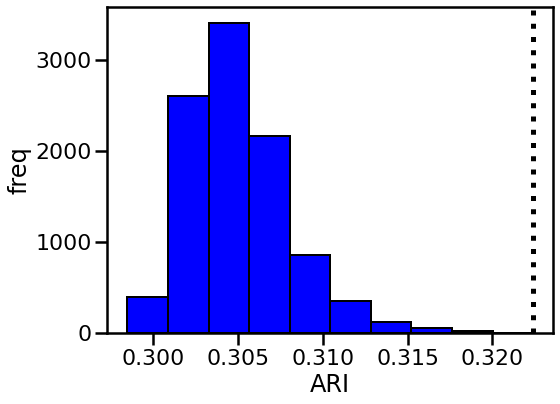

In [ ]:
# Plot histogram
plt.hist(media_permutada_W_N2, bins=10, color='blue', edgecolor='k')

# Vertical line
plt.axvline(W_N2, color='k', linestyle='dotted', linewidth=5)

plt.ylabel('freq')
plt.xlabel('ARI')

# Display
plt.show()

In [ ]:
W_N3 = (np.mean(ari_N3) + np.mean(ari_W)) / 2

permuta_es_mayor = 0
for i in media_permutada_W_N3:
  if i > W_N3:
    permuta_es_mayor += 1

pvalor = permuta_es_mayor / len(media_permutada_W_N3)
print("N3:")
print("El ARI observado es " + str(W_N3))
print("El ARI permutado es " + str(np.mean(media_permutada_W_N3)))
print("Hay " + str(permuta_es_mayor) + " ARIs permutados mayores que el ARI observado")
print("Esto da un p-value de "+ str(pvalor))

N3:
El ARI observado es 0.2970820209211157
El ARI permutado es 0.2863117445582388
Hay 2 ARIs permutados mayores que el ARI observado
Esto da un p-value de 0.0002


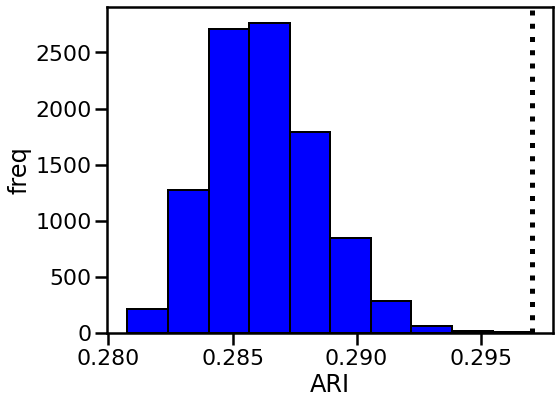

In [ ]:
# Plot histogram
plt.hist(media_permutada_W_N3, bins=10, color='blue', edgecolor='k')

# Vertical line
plt.axvline(W_N3, color='k', linestyle='dotted', linewidth=5)

plt.ylabel('freq')
plt.xlabel('ARI')

# Display
plt.show()